In [1]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
from pandas.tseries.frequencies import to_offset
import datetime
import numpy as np
import itertools
import math
import seaborn as sns
import matplotlib.pyplot as plt
from chart_studio.plotly import plot_mpl
from datetime import datetime


%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [36]:
nvidia = pd.read_csv('./data/Nvidia_history.csv')
amd = pd.read_csv('./data/AMD_stock_price_history.csv')
nvidia_trend = pd.read_csv('./data/Nvidia_google_trend.csv')

In [37]:
nvidia

,Date,Open,High,Low,Close,Adj Close,Volume,Revenue,Future,Market_share
0,1/22/1999,1.750000,1.953125,1.552083,1.640625,1.507891,67867200,NaN,NaN,NaN
1,1/25/1999,1.770833,1.833333,1.640625,1.812500,1.665861,12762000,NaN,NaN,NaN
2,1/26/1999,1.833333,1.869792,1.645833,1.671875,1.536613,8580000,NaN,NaN,NaN
3,1/27/1999,1.677083,1.718750,1.583333,1.666667,1.531826,6109200,NaN,NaN,NaN
4,1/28/1999,1.666667,1.677083,1.651042,1.661458,1.527039,5688000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5624,5/28/2021,620.039978,651.099976,620.039978,649.780029,649.780029,16113400,$5.66B,NaN,80.0
5625,6/1/2021,650.799988,655.530029,636.130005,650.580017,650.580017,11820100,$5.66B,NaN,80.0
5626,6/2/2021,650.090027,676.750000,649.419983,671.130005,671.130005,14854200,$5.66B,NaN,80.0
5627,6/3/2021,668.030029,690.359985,663.320007,678.789978,678.789978,14500200,$5.66B,NaN,80.0


In [38]:
nvidia['daily_change'] = (nvidia.Close - nvidia.Open) / nvidia.Open * 100

In [39]:
nvidia['daily_change'] = nvidia['daily_change'].shift(1)
nvidia.drop(columns=['Volume', 'Open', 'High', 'Low', 'Adj Close'], inplace=True)
nvidia1 = nvidia['Revenue'].str.strip('$').str.extract(r'(\d+\.\d+)([BM]+)')
nvidia['Revenue'] = nvidia1[0].astype(float) * nvidia1[1].map({'B': 1000000000, 'M':1000000})

In [40]:
amd['previous_amd_close_price'] = amd['Close'].shift(1)
amd.drop(columns=['Open', 'High', 'Low', 'Adj Close','Volume', 'Close'], inplace=True)

In [41]:
amd

,Date,previous_amd_close_price
0,3/17/1980,NaN
1,3/18/1980,3.145833
2,3/19/1980,3.031250
3,3/20/1980,3.041667
4,3/21/1980,3.010417
...,...,...
10394,6/7/2021,81.580002
10395,6/8/2021,81.349998
10396,6/9/2021,80.889999
10397,6/10/2021,79.959999


In [42]:
nvidia = nvidia.merge(amd, on='Date', how='left')

In [43]:
nvidia

,Date,Close,Revenue,Future,Market_share,daily_change,previous_amd_close_price
0,1/22/1999,1.640625,NaN,NaN,NaN,NaN,10.500000
1,1/25/1999,1.812500,NaN,NaN,NaN,-6.250000,10.781250
2,1/26/1999,1.671875,NaN,NaN,NaN,2.352960,10.718750
3,1/27/1999,1.666667,NaN,NaN,NaN,-8.806802,11.000000
4,1/28/1999,1.661458,NaN,NaN,NaN,-0.621078,10.625000
...,...,...,...,...,...,...,...
5624,5/28/2021,649.780029,5.660000e+09,NaN,80.0,-1.348743,78.419998
5625,6/1/2021,650.580017,5.660000e+09,NaN,80.0,4.796473,80.080002
5626,6/2/2021,671.130005,5.660000e+09,NaN,80.0,-0.033800,80.809998
5627,6/3/2021,678.789978,5.660000e+09,NaN,80.0,3.236471,81.970001


In [44]:
nvidia_trend

,Month,Nvidia
0,2004-01,96
1,2004-02,80
2,2004-03,88
3,2004-04,84
4,2004-05,79
...,...,...
205,2021-02,37
206,2021-03,33
207,2021-04,33
208,2021-05,33


In [45]:
trend = []
for date in nvidia['Date']:
    month = date.split('/')[0]
    if int(month) < 10:
        month = f'0{month}'
    else:
        month = month
    year = date.split('/')[2]
    year_month = f'{year}-{month}'
    if int(year) < 2004:
        trend.append(0)
    else:
        trend.append(int(nvidia_trend.Nvidia[nvidia_trend.Month == year_month]))

In [46]:
nvidia['trend'] = trend
nvidia['trend'] = nvidia['trend'].astype(int)

In [47]:
nvidia['Date'] = pd.to_datetime(nvidia['Date'])

nvidia = nvidia.set_index('Date')

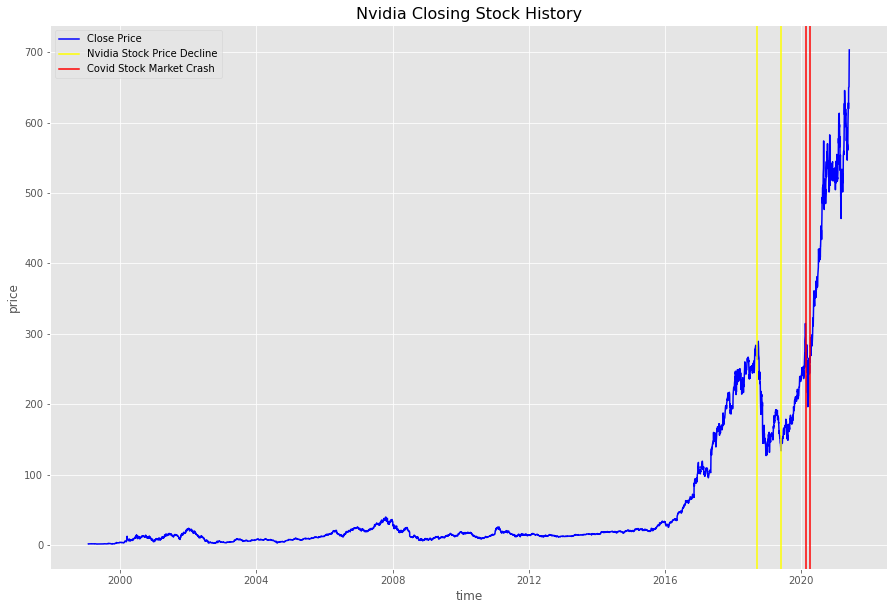

In [48]:
plt.figure(figsize=(15,10))
plt.plot(nvidia.Close, color='blue',label='Close Price')
plt.axvline(x='2018-09-16', color='yellow')
plt.axvline(x='2019-06-01', color='yellow', label='Nvidia Stock Price Decline')
plt.axvline(x='2020-02-20', color='red')
plt.axvline(x='2020-04-07', color='red', label='Covid Stock Market Crash')
plt.legend(loc='best')
plt.title('Nvidia Closing Stock History', fontsize=16)
plt.xlabel("time")
plt.ylabel("price")
plt.savefig('./images/nvidia_stock_history.png')
plt.show()

In [49]:
nvidia = nvidia[nvidia.index >= '2019-06-01']

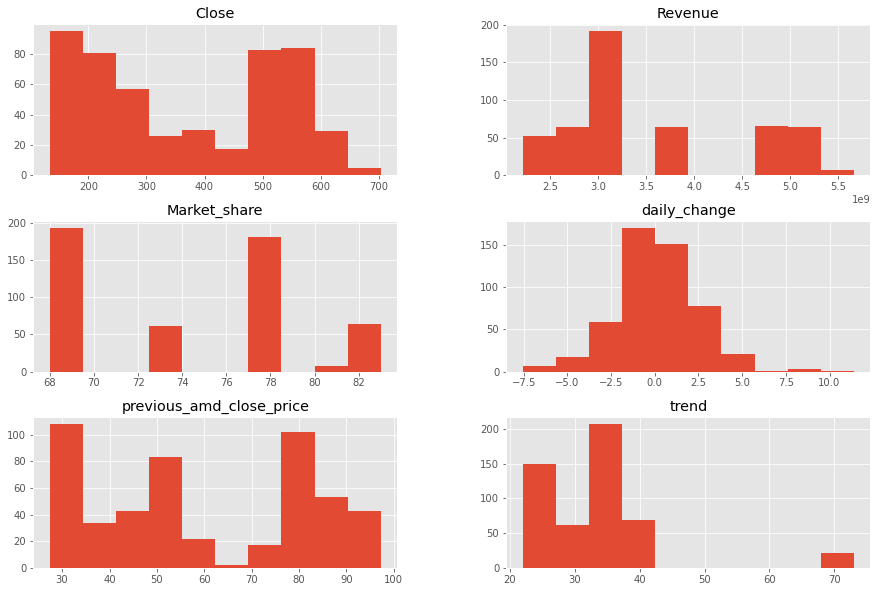

In [50]:
fig, ax = plt.subplots(figsize = (15,10))
nvidia.hist(bins = 10, ax=ax)
fig.savefig('./images/variables_distribution.png')

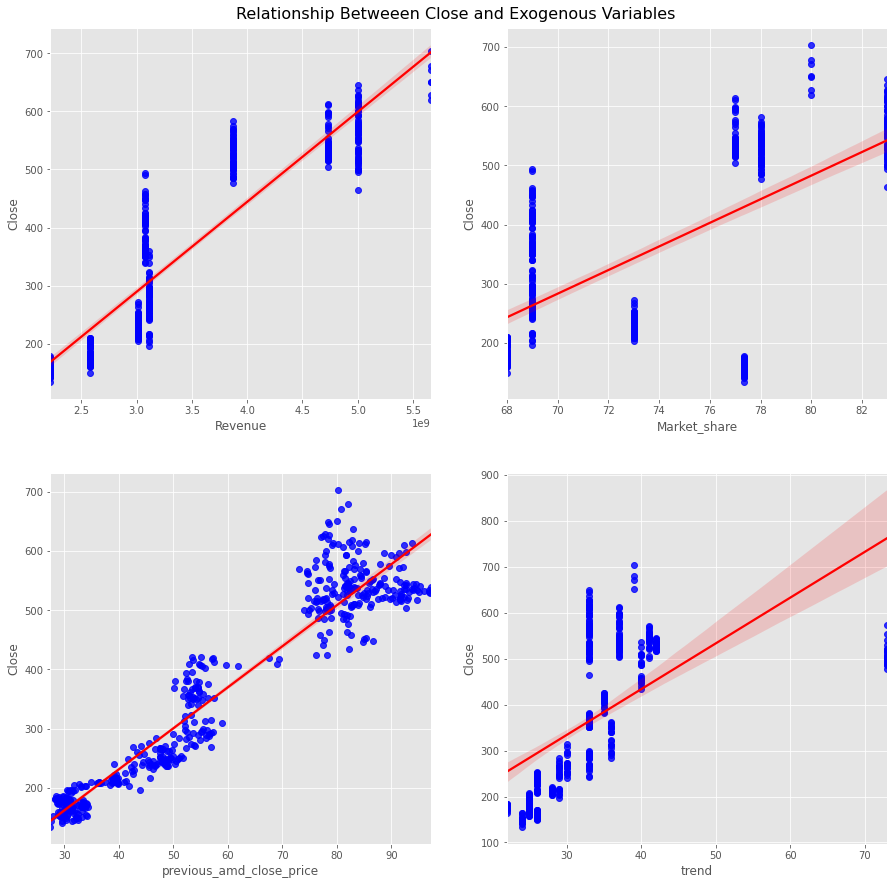

In [51]:
# create regression plots to check the relationship between price and other variables
fig, axes = plt.subplots(2, 2, figsize=(15,15))
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]
X = nvidia.drop('Close', axis = 1)
y = nvidia['Close']
fig.suptitle('Relationship Betweeen Close and Exogenous Variables', fontsize=16, y=0.9)
sns.regplot(x=X['Revenue'], y=y, line_kws={"color": "red"}, ax=ax1, color='blue')
sns.regplot(x=X['Market_share'], y=y, line_kws={"color": "red"}, ax=ax2, color='blue')
sns.regplot(x=X['previous_amd_close_price'], y=y, line_kws={"color": "red"}, ax=ax3, color='blue')
sns.regplot(x=X['trend'], y=y, line_kws={"color": "red"}, ax=ax4, color='blue')
fig.savefig('./images/close_variables_relationship.png')

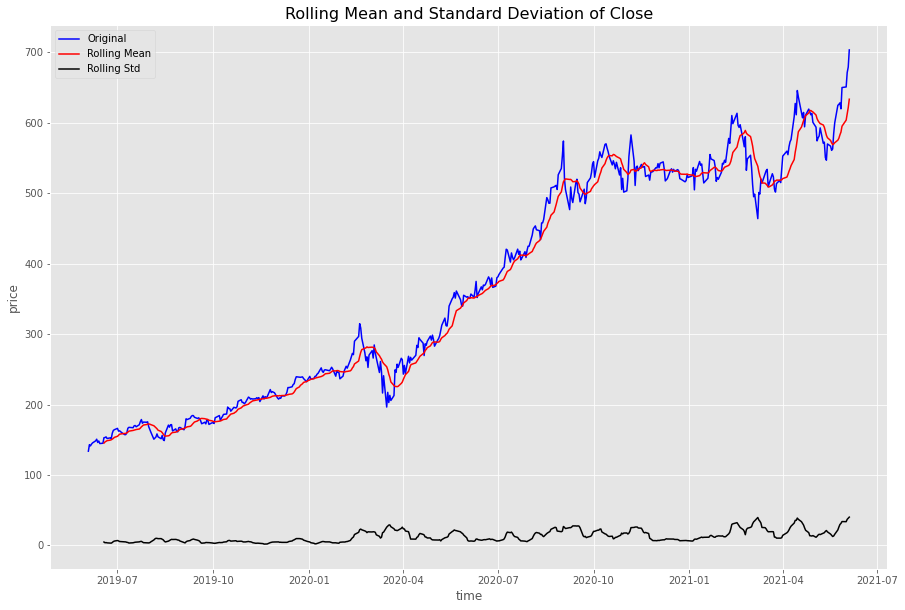

Results of dickey fuller test
Test Statistics                  0.110537
p-value                          0.966773
No. of lags used                 1.000000
Number of observations used    505.000000
critical value (1%)             -3.443366
critical value (5%)             -2.867280
critical value (10%)            -2.569827
dtype: float64


In [52]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(15,10))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Close', fontsize=16)
    plt.xlabel("time")
    plt.ylabel("price")
    plt.savefig('./images/close_rolling_mean_std.png')
    plt.show()
    
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
    
test_stationarity(nvidia.Close)


No handles with labels found to put in legend.


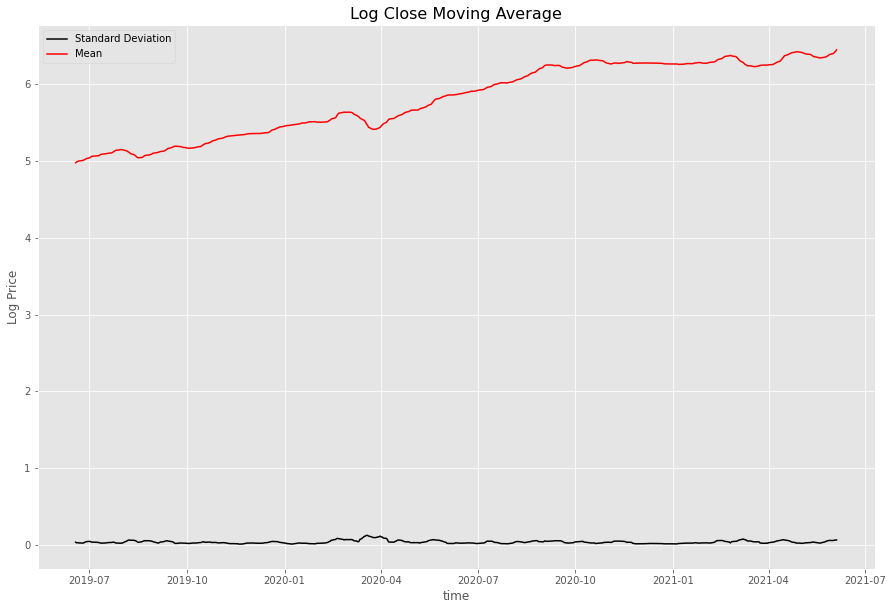

In [53]:
rcParams['figure.figsize'] = 10, 6
nvidia_stock_log = np.log(nvidia.Close)
moving_avg = nvidia_stock_log.rolling(12).mean()
std_dev = nvidia_stock_log.rolling(12).std()
plt.figure(figsize=(15,10))
plt.legend(loc='best')
plt.title('Log Close Moving Average', fontsize=16)
plt.xlabel("time")
plt.ylabel("Log Price")
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.savefig('./images/log_close_moving_average.png')
plt.show()

<Figure size 720x432 with 0 Axes>

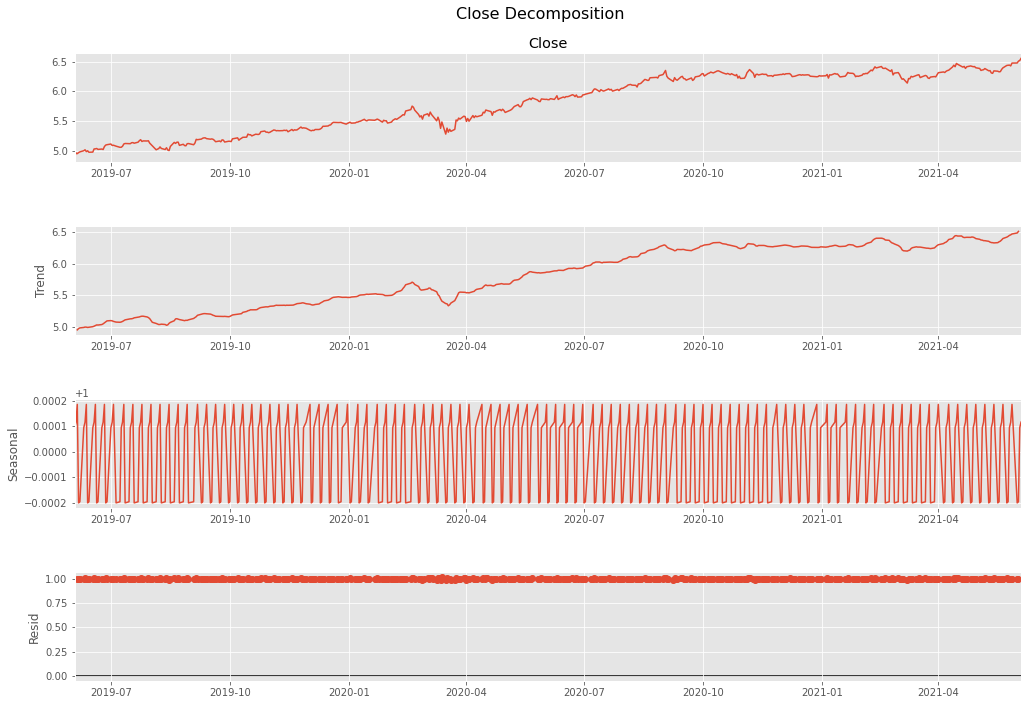

In [54]:
result = seasonal_decompose(nvidia_stock_log, model='multiplicative', period=5)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)
fig.suptitle('Close Decomposition', fontsize=16, x = 0.54, y=1)
fig.savefig('./images/close_dcompose.png')

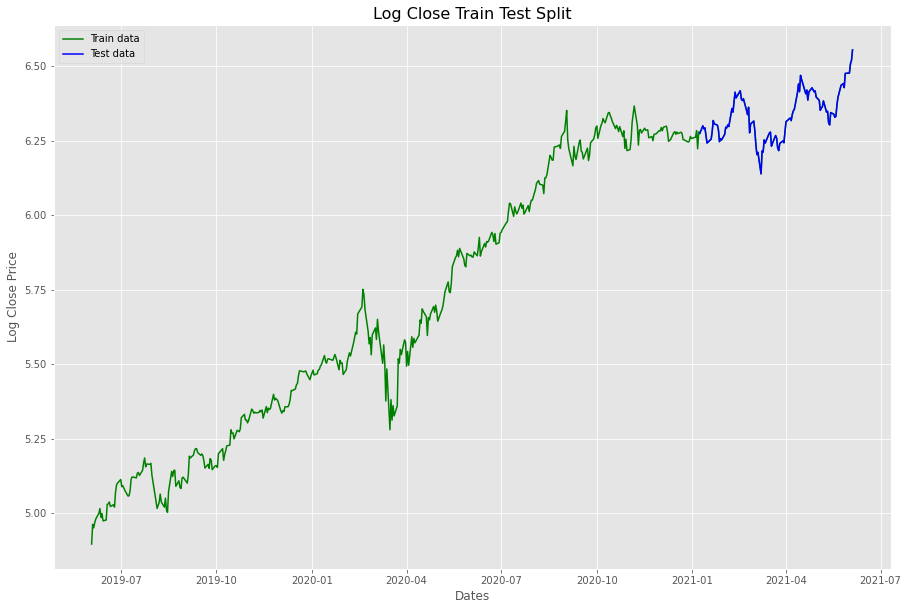

In [55]:
train_data, test_data = nvidia_stock_log[3:int(len(nvidia_stock_log)*0.80)], nvidia_stock_log[int(len(nvidia_stock_log)*0.80):]
plt.figure(figsize=(15,10))
plt.grid(True)
plt.title('Log Close Train Test Split', fontsize=16)
plt.xlabel('Dates')
plt.ylabel('Log Close Price')
plt.plot(nvidia_stock_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.savefig('./images/log_close_train_test_split.png')

In [56]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1612.309, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1638.257, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1633.260, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1610.205, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1638.992, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1637.173, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1637.046, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1638.221, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1635.039, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1635.333, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.457 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  402
Model:               SARIMAX(2, 1, 0)   Log Likeliho

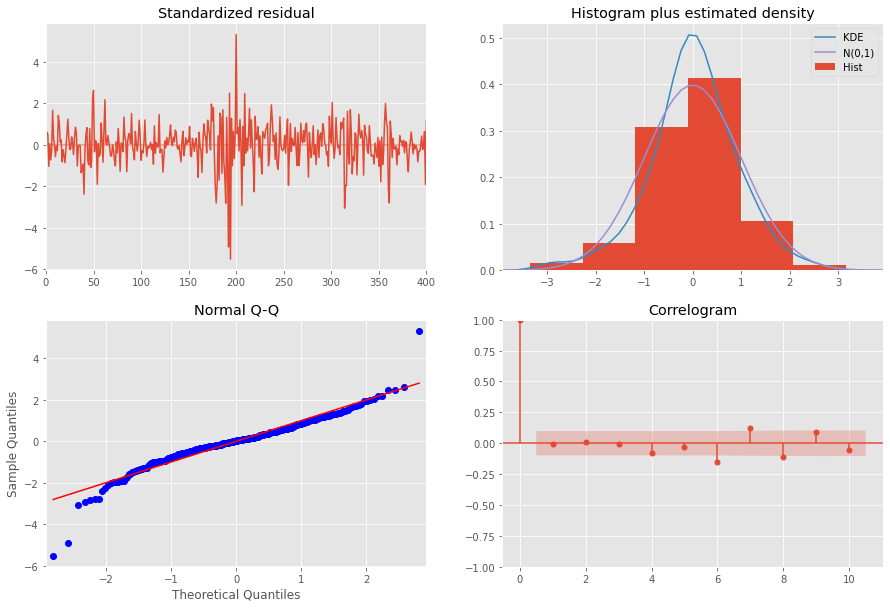

In [57]:
model_autoARIMA.plot_diagnostics(figsize=(15,10))
plt.savefig('./images/plot_diagnostics_ARIMA.png')
plt.show()

In [58]:
train_data.head()

Date
2019-06-06    4.968284
2019-06-07    4.980176
2019-06-10    5.000113
2019-06-11    5.015623
2019-06-12    4.984976
Name: Close, dtype: float64

In [59]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  401
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 823.496
Method:                       css-mle   S.D. of innovations              0.031
Date:                Wed, 16 Jun 2021   AIC                          -1638.992
Time:                        01:33:31   BIC                          -1623.016
Sample:                             1   HQIC                         -1632.666
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.001      2.418      0.016       0.001       0.006
ar.L1.D.Close    -0.2390      0.050     -4.801      0.000      -0.337      -0.141
ar.L2.D.Close     0.0828      0.050     

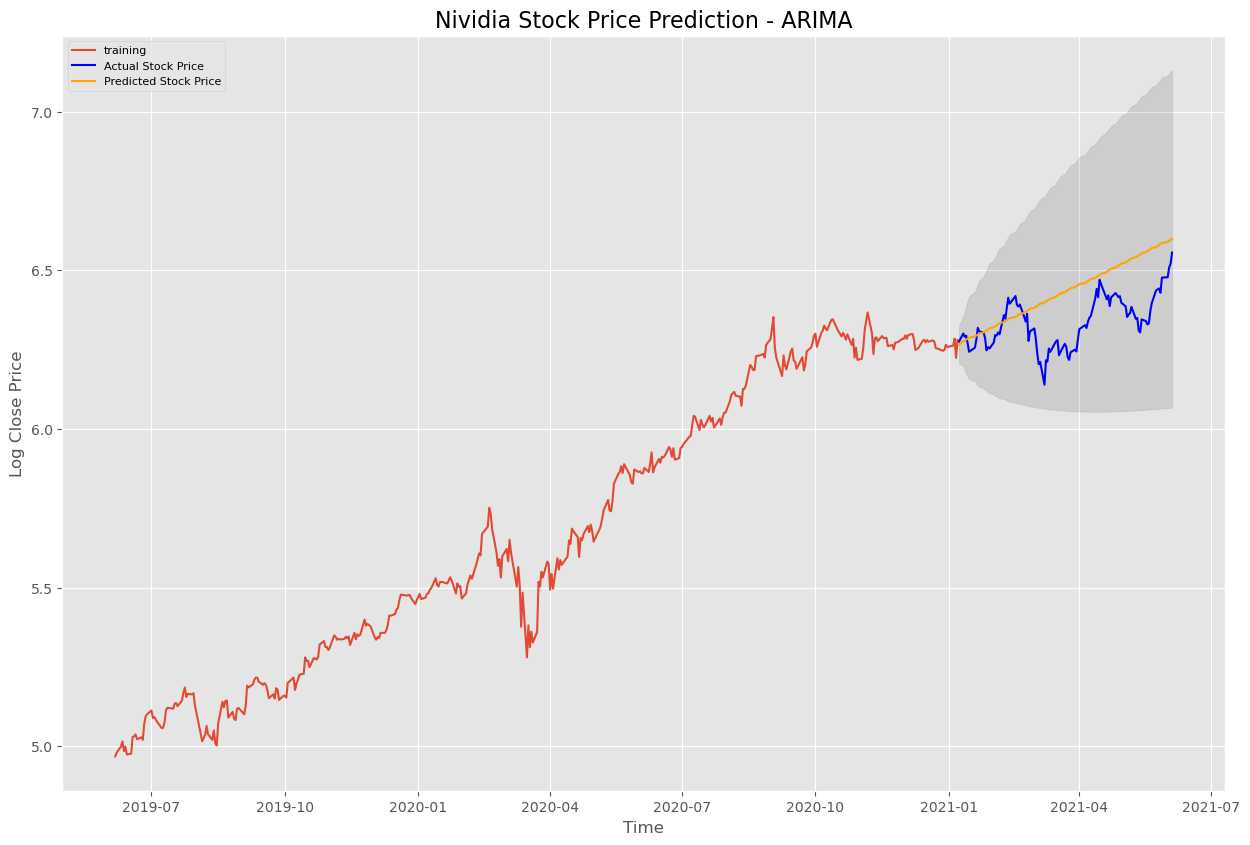

In [60]:
# Forecast
fc, se, conf = fitted.forecast(102, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(15,10), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nividia Stock Price Prediction - ARIMA', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Log Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('./images/ARIMA_prediction_result.png')
plt.show()

In [61]:
MSE = np.square(np.subtract(test_data,fc_series)).mean() 
 
RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE/test_data.mean())

RMSE: 0.12886578268744206
%RMSE:  0.020339099660274453


In [62]:
# n_periods = 24
# fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)


date_string = "2021-06-09"
date = datetime.strptime(date_string, "%Y-%m-%d")

fc, se, conf = fitted.forecast(5, alpha=0.05)
index_of_fc = np.arange(nvidia_stock_log.index[-1], date)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(conf[:, 0], index=index_of_fc)
upper_series = pd.Series(conf[:, 1], index=index_of_fc)

# Plot
plt.plot(nvidia_stock_log)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

MemoryError: Unable to allocate 3.14 TiB for an array with shape (432000000000,) and data type datetime64[us]

In [63]:
nvidia_stock_log.index

DatetimeIndex(['2019-06-03', '2019-06-04', '2019-06-05', '2019-06-06',
               '2019-06-07', '2019-06-10', '2019-06-11', '2019-06-12',
               '2019-06-13', '2019-06-14',
               ...
               '2021-05-21', '2021-05-24', '2021-05-25', '2021-05-26',
               '2021-05-27', '2021-05-28', '2021-06-01', '2021-06-02',
               '2021-06-03', '2021-06-04'],
              dtype='datetime64[ns]', name='Date', length=507, freq=None)

In [64]:
exo_df = nvidia.drop(columns=['Close', 'Future', 'trend', 'Revenue', 'Market_share'])
train_exo_data, test_exo_data = exo_df[3:int(len(exo_df)*0.80)], exo_df[int(len(exo_df)*0.80):]

In [65]:
model_autoARIMA_exo = auto_arima(train_data, exogenous=train_exo_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA_exo.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1620.925, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1637.493, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1629.299, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1617.658, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1641.272, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1642.676, Time=0.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1638.614, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1640.069, Time=0.56 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-1639.829, Time=0.45 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 3.211 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  402
Model:               SARIMAX(3, 1, 0)   Log Likelihood                 828.338
Date:                Wed, 16 Jun 2021   

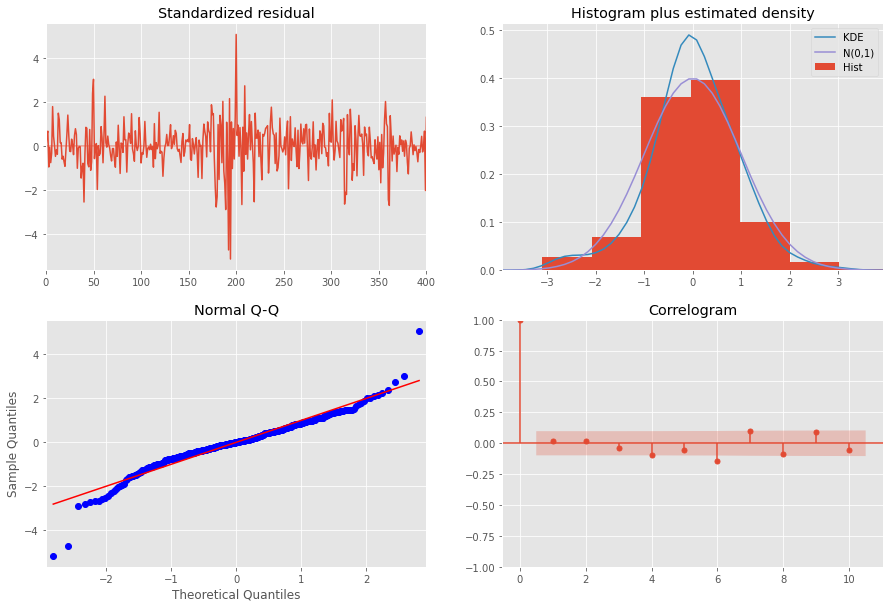

In [70]:
model_autoARIMA_exo.plot_diagnostics(figsize=(15,10))
plt.savefig('./images/plot_diagnostics_ARIMA_exo.png')
plt.show()

In [67]:
model2 = ARIMA(train_data, exog=train_exo_data, order=(3, 1, 0))  
fitted = model2.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  401
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 825.737
Method:                       css-mle   S.D. of innovations              0.031
Date:                Wed, 16 Jun 2021   AIC                          -1637.473
Time:                        01:33:44   BIC                          -1609.515
Sample:                             1   HQIC                         -1626.402
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0057      0.004      1.583      0.114      -0.001       0.013
daily_change                 0.0018      0.001      1.933      0.053   -2.44e-05       0.

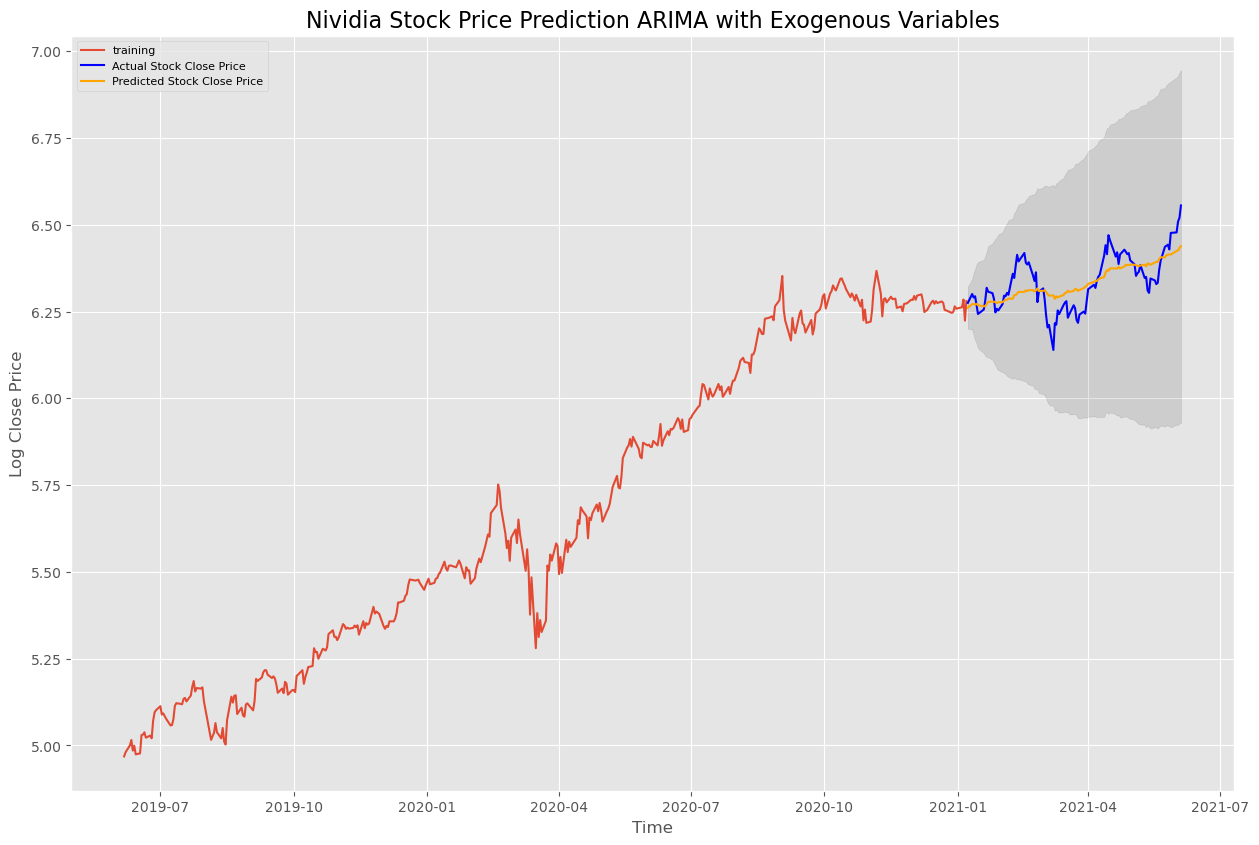

In [68]:
# Forecast
fc, se, conf = fitted.forecast(102, exog=test_exo_data, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(15,10), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Close Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Close Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nividia Stock Price Prediction ARIMA with Exogenous Variables', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Log Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('./images/ARIMA_exo_prediction_result.png')
plt.show()

In [69]:
MSE = np.square(np.subtract(test_data,fc_series)).mean() 
 
RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE/test_data.mean())

RMSE: 0.054791043829082085
%RMSE:  0.008647761086688872


In [519]:
nvidia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1365 entries, 2016-01-04 to 2021-06-04
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Close                         1365 non-null   float64
 1   Revenue                       1240 non-null   float64
 2   Future                        1030 non-null   object 
 3   Market_share                  1365 non-null   float64
 4   daily_change                  1365 non-null   float64
 5   previous_vol_mutiplie_change  1365 non-null   float64
 6   previous_bitcoin_close_price  1365 non-null   float64
 7   trend                         1365 non-null   int32  
dtypes: float64(6), int32(1), object(1)
memory usage: 90.6+ KB


(array([0.00142272, 0.00369906, 0.01308898, 0.05890041, 0.20515553,
        0.13885701, 0.03357608, 0.00341452, 0.00113817, 0.00085363]),
 array([-10.38111455,  -8.20770281,  -6.03429108,  -3.86087934,
         -1.6874676 ,   0.48594414,   2.65935587,   4.83276761,
          7.00617935,   9.17959108,  11.35300282]),
 <BarContainer object of 10 artists>)

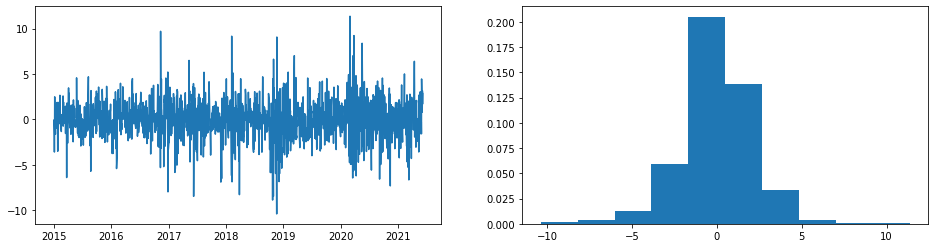

In [584]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

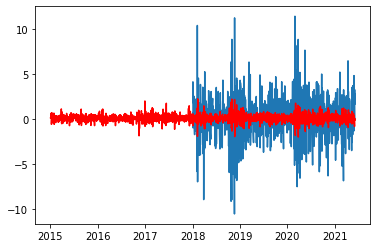

In [585]:
plt.plot(df.daily_change)
plt.plot(result.fittedvalues, color='red')
plt.show()

In [ ]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

In [ ]:
start = datetime.datetime(2020,2,1)
end = datetime.datetime(2020,10,11)

In [ ]:
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [ ]:
Symbols = companies['Symbol'].tolist()

In [ ]:
# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

In [ ]:
stock_final.head()

In [ ]:
https://trends.google.com/trends/explore?q=nvidia&geo=US

In [ ]:
https://docs.github.com/en/github/setting-up-and-managing-your-github-profile/managing-contribution-graphs-on-your-profile/why-are-my-contributions-not-showing-up-on-my-profile